## Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation ,       MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import shutil
import pandas as pd
import random
import matplotlib.pyplot as plt

## Dataset Preparation

### Reading images

In [2]:
csv_file = pd.read_csv('ISIC_2019_Training_GroundTruth (2).csv')
image_path = []
column_name = ['Melanoma', 'Melanocytic nevus' , 'Basal cell carcinoma' ,'Actinic  keratosis','Benign keratosis', 'Dermatofibrona','Vascular lesion','Squamous cell carcinoma']
disease_list = csv_file.iloc[:,1:9]
image_name = csv_file.iloc[:,0]
dir = 'ISIC_2019_Training_Input'
for name in image_name:
    fpath = os.path.join(dir, name+'.jpg')
    image_path.append(fpath)          

In [3]:
os.makedirs("segregation_training1",exist_ok=True)
for names in column_name:
    os.makedirs(f"segregation_training1/{names}",exist_ok=True)

os.makedirs("segregation_testing1",exist_ok=True)
for names in column_name:
    os.makedirs(f"segregation_testing1/{names}",exist_ok=True)

os.makedirs("segregation_validation1",exist_ok=True)
for names in column_name:
    os.makedirs(f"segregation_validation1/{names}",exist_ok=True)
    
for index in range(0 , 8):
    for index_number , value in enumerate(disease_list.iloc[:,index]):
        #disease_name = column_name[index]
        if value == 1.0:
            if random.random()<0.7:
                shutil.copy(image_path[index_number],f"segregation_training1/{column_name[index]}")
            elif random.random()<0.85:
                shutil.copy(image_path[index_number],f"segregation_validation1/{column_name[index]}")
            else:
                shutil.copy(image_path[index_number],f"segregation_testing1/{column_name[index]}")
                
            
            
            
        

In [4]:
# One-hot encode disease labels
num_classes = len(column_name)  # Assuming each column represents a class
one_hot_labels = tf.keras.utils.to_categorical(disease_list, num_classes)


## Importing the NASnet model

In [5]:
model_url = "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4"
NASNet_mobile = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))  # Download weights explicitly

# Create your classification head
model = tf.keras.Sequential([
    NASNet_mobile,
    layers.Flatten(),
    layers.Dense(128, activation="sigmoid"),  # Optional hidden layer
    layers.Dense(num_classes, activation="softmax")  # Output layer for binary classification
])


# Compile the model
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

model.compile(
    optimizer= 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=METRICS,
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 10,287,304
Trainable params: 10,253,192
Non-trainable params: 34,112
_________________________________________________________________
None


In [6]:
# Define data generators for training and validation sets (recommended for large datasets)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
img_width, img_height = 224, 224
batch_size = 16
# Create training and validation data generators
train_generator = train_datagen.flow_from_directory(
    'segregation_training1',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
    )

val_generator = val_datagen.flow_from_directory(
    'segregation_validation1',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
    
)

# Train the model
history = model.fit(train_generator,
          epochs=1,  # Adjust number of epochs based on your dataset size
          validation_data=val_generator,
                    )



Found 17736 images belonging to 8 classes.
Found 6498 images belonging to 8 classes.
1109/1109 [==============================] - 1541s 1s/step - loss: 1.2985 - accuracy: 0.9031 - precision: 0.6916 - recall: 0.4061 - auc: 0.8761 - val_loss: 1.6498 - val_accuracy: 0.8777 - val_precision: 0.5106 - val_recall: 0.5106 - val_auc: 0.8293


## Displaying the metrics 

[1.298478603363037]


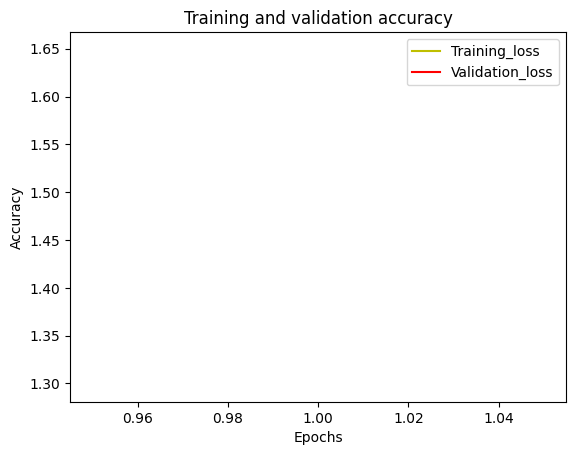

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
print(loss )
epochs = range (1, len(loss) + 1)
plt.plot(epochs , loss , 'y' , label = "Training_loss")
plt.plot(epochs , val_loss,'r' , label = "Validation_loss")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

KeyError: 'acc'

In [13]:
# Load test data generator (similar to training and validation)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'segregation_testing1',  # Replace with path to your test data folder
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model on the test data
print(model.evaluate(test_generator))




Found 1097 images belonging to 8 classes.
35/35 [==============================] - 15s 420ms/step - loss: 1.6333 - accuracy: 0.8765 - precision: 0.5059 - recall: 0.5059 - auc: 0.8373
[1.6333141326904297, 0.876481294631958, 0.5059252381324768, 0.5059252381324768, 0.8372557759284973]


NameError: name 'test_acc' is not defined